# Import libraries

In [52]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Import Functions

### dslabs_functions

In [32]:
%run "scripts/dslabs_functions.py"

dslabs_functions lodaded


### data functions

In [34]:
%run "scripts/data_functions.py"


data_functions lodaded


# Load

In [82]:

#get file from data pre processing notebook. This file has all the column we need to start the data profiling phase
filepath = r'data/city_bike_pre_proc.csv'

excel_mapping_filepath=r'data/citi_bike_values_encoded.xlsx'

file_tag = 'Citi Bike'

#get file from data pre processing notebook. This file has all the column we need to start the data profiling phase

In [84]:
test_data = False
# test_data = False

# Load the data
if test_data:
    df = pd.read_csv(filepath, na_values="")

    df: DataFrame = df.sample(frac=0.0015, replace = False)

else:
    # If not test_data, load the entire dataset
    df = pd.read_csv(filepath)

id_cols=['ride_id','start_time', 'end_time','start_station','end_station','start_station_id','end_station_id','start_lat','start_lng', 'end_lat', 'end_lng','wmo_weather_code','snowfall_cm','ride_duration_sec']
#remove also col = 'snowfall_cm' because it has only 0 values in our dataset
#remove also start_station and end_Station = they have too many unique values(around 2k) which will make the encoding process very slow

df=df.drop(columns=id_cols, axis=1)

# encoded dataframe duplication
df_enc = df.copy()

df_enc.info()

df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3193597 entries, 0 to 3193596
Data columns (total 17 columns):
 #   Column               Dtype  
---  ------               -----  
 0   bike_type            object 
 1   user_type            object 
 2   start_borough        object 
 3   end_borough          object 
 4   day_of_month         int64  
 5   hour                 int64  
 6   day_of_week          object 
 7   is_weekend           int64  
 8   time_of_day          object 
 9   ride_duration_min    float64
 10  temperature_2m       float64
 11  rain_mm              float64
 12  cloud_cover_low_pct  int64  
 13  wind_speed_10m       float64
 14  wmo_weather_desc     object 
 15  ride_distance_km     float64
 16  ride_avg_speed       float64
dtypes: float64(6), int64(4), object(7)
memory usage: 414.2+ MB


,bike_type,user_type,start_borough,end_borough,day_of_month,hour,day_of_week,is_weekend,time_of_day,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed
0,electric_bike,member,Manhattan,Manhattan,27,13,Saturday,1,lunch time,9.161483,14.3,0.0,16,25.3,Overcast,2.037884,13.346422
1,electric_bike,member,Manhattan,Manhattan,25,15,Thursday,0,afternoon,4.639433,11.2,0.0,0,13.7,Clear sky,1.447460,18.719442
2,electric_bike,member,Manhattan,Manhattan,6,11,Saturday,1,late morning,6.865817,9.6,0.0,95,27.9,Overcast,1.785276,15.601426
3,electric_bike,member,Brooklyn,Brooklyn,6,16,Saturday,1,afternoon,2.289150,10.7,0.0,11,25.4,Overcast,0.431973,11.322269
4,electric_bike,member,Manhattan,Manhattan,10,17,Wednesday,0,evening,7.947850,15.0,0.0,44,10.7,Partly cloudy,1.376807,10.393806
5,electric_bike,member,Manhattan,Brooklyn,7,14,Sunday,1,afternoon,27.290533,13.4,0.0,0,22.3,Overcast,2.404062,5.285486
6,electric_bike,member,Manhattan,Manhattan,25,18,Thursday,0,evening,10.656417,7.9,0.0,0,15.4,Clear sky,2.072039,11.666429
7,electric_bike,member,Brooklyn,Brooklyn,14,14,Sunday,1,afternoon,23.607000,20.8,0.0,0,21.3,Overcast,4.927812,12.524620
8,electric_bike,member,Manhattan,Manhattan,17,12,Wednesday,0,lunch time,10.698533,15.4,0.0,79,18.2,Overcast,2.572462,14.427000
9,electric_bike,member,Manhattan,Manhattan,26,9,Friday,0,late morning,7.501383,10.4,0.0,0,4.4,Clear sky,1.758236,14.063292


In [86]:
# Verificar se 'event_time' está presente e é do tipo datetime
if 'event_time' in df.columns and pd.api.types.is_datetime64_any_dtype(df['event_time']):
    # Conta o número de dias únicos
    num_unique_days = df['event_time'].nunique()
    print(f"Número de dias únicos: {num_unique_days}")
else:
    print("A coluna 'event_time' não existe ou não é do tipo datetime.")

# Contar valores distintos em todas as colunas
distinct_values = df.nunique()
print("Número de valores distintos por coluna:")
print(distinct_values)

A coluna 'event_time' não existe ou não é do tipo datetime.
Número de valores distintos por coluna:
bike_type                    2
user_type                    2
start_borough                6
end_borough                  7
day_of_month                31
hour                        24
day_of_week                  7
is_weekend                   2
time_of_day                  6
ride_duration_min      1410275
temperature_2m             214
rain_mm                     30
cloud_cover_low_pct         73
wind_speed_10m             258
wmo_weather_desc             9
ride_distance_km       2194836
ride_avg_speed         3159469
dtype: int64


In [87]:
df.shape

(3193597, 17)

# Data Preparation
- Goal is to improve the quality of the data

#### List of distinct values for each variable

In [88]:
from pandas import Series, DataFrame, to_numeric, to_datetime

def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    
    for c in df.columns:
        if 2 == nr_values[c]:  # Colunas com exatamente 2 valores únicos
            variable_types["binary"].append(c)
        else:
            if df[c].dtype == 'datetime64[ns, UTC]':  # Verifica se a coluna já é datetime
                variable_types["date"].append(c)
            else:
                try:
                    df[c] = to_numeric(df[c], errors="raise")
                    variable_types["numeric"].append(c)
                except ValueError:
                    try:
                        df[c] = to_datetime(df[c], errors="raise")
                        variable_types["date"].append(c)
                    except ValueError:
                        variable_types["symbolic"].append(c)

    return variable_types

# Uso da função
variable_types: dict[str, list] = get_variable_types(df)
print(variable_types)

{'numeric': ['day_of_month', 'hour', 'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed'], 'binary': ['bike_type', 'user_type', 'is_weekend'], 'date': [], 'symbolic': ['start_borough', 'end_borough', 'day_of_week', 'time_of_day', 'wmo_weather_desc']}


In [89]:
for v in variable_types["symbolic"]:
    print(v, df[v].unique())

start_borough ['Manhattan' 'Brooklyn' 'Queens' 'Bronx' 'Staten Island' 'Jersey City']
end_borough ['Manhattan' 'Brooklyn' 'Queens' 'Bronx' 'Staten Island' 'Jersey City'
 'Hoboken']
day_of_week ['Saturday' 'Thursday' 'Wednesday' 'Sunday' 'Friday' 'Monday' 'Tuesday']
time_of_day ['lunch time' 'afternoon' 'late morning' 'evening' 'early morning' 'night']
wmo_weather_desc ['Overcast' 'Clear sky' 'Partly cloudy' 'Mainly clear' 'Drizzle: Light'
 'Rain: Slight' 'Drizzle: Moderate' 'Drizzle: Dense' 'Rain: Moderate']


In [90]:
# Verificar se 'event_time' está presente e é do tipo datetime
if 'event_time' in df.columns and pd.api.types.is_datetime64_any_dtype(df['event_time']):
    # Conta o número de dias únicos
    num_unique_days = df['event_time'].nunique()
    print(f"Número de dias únicos: {num_unique_days}")
else:
    print("A coluna 'event_time' não existe ou não é do tipo datetime.")

# Contar valores distintos em todas as colunas
distinct_values = df.nunique()
print("Número de valores distintos por coluna:")
print(distinct_values)

A coluna 'event_time' não existe ou não é do tipo datetime.
Número de valores distintos por coluna:
bike_type                    2
user_type                    2
start_borough                6
end_borough                  7
day_of_month                31
hour                        24
day_of_week                  7
is_weekend                   2
time_of_day                  6
ride_duration_min      1410275
temperature_2m             214
rain_mm                     30
cloud_cover_low_pct         73
wind_speed_10m             258
wmo_weather_desc             9
ride_distance_km       2194836
ride_avg_speed         3159469
dtype: int64


# Encoding
- we need to do the enconding of the symoblic and cyclical vraibles of the dataset
    - Simbolyc
        - start_station
        - end_station
        - start_borough
        - end_borough
        - wmo_weather_desc

    - Cyclical
        - time_of_day
        - day_of_week
        - hour
        - day_of_week
        - time_of_day
    
    - Numeric (already numeric, no need to encode)
        - ride_duration_min
        - day_of_month
        - temperature_2m
        - rain_mm
        - wmo_weather_code
        - cloud_cover_low_pct
        - wind_speed_10m
        - ride_distance_km
        - ride_avg_speed


    - Binary
        - bike_type
        - user_type
        - is_weekend (already numeric, no need to encode)

# Encoding Detail

- Ordinal enconding:
  - bike_type
    - 0: classic
    - 1: eletric
  - user_type
    - 0: casual
    - 1: member

- Hierachical encoding: Simbolyic Variables
  - start_station
    - (don't consider for now as the encoding of these variables would be realy dificult because we have 2000 diferente stations)
  - end_station
    - (don't consider for now as the encoding of these variables would be realy dificult because we have 2000 diferente stations)
 

- Cyclical enconding: Simbolyic Variables
  - day_of_week
  - time_of_day
  - hour

- Dummyfication:
  - start_borough
  - end_borough
  - wmo_weather_desc 


- Numeric Values that don't need encoding
  - hour
  - day_of_month
  - is_weekend
  - ride_duration_min
  - temperature_2m
  - rain_mm
  - wmo_weather_code ?????
  - cloud_cover_low_pct
  - wind_speed_10m
  - ride_distance_km
  - ride_avg_speed

Note: week_of_month and day in our case are ordinal variables, and not cyclical, because our dataset only has data for 1 month, nov/19, which means that these two variables don't repeat over time in our dataset.

#### Ordinal enconding

For these variables, they are cyclical. However, as we only have data for 1 month in our dataset, there are some variables that will not repeat in our dataset. So for this variables will make the hierarchy according to the proximity in time of the values:
Ex: week 1, is more close to week 2, than to week 5
- week_of_month
- day

For event_type, we are doing the hiearchy accoring to the proximity of the events in the user journey inside the website
ex: view, is more close to view_cart than to purchase
- event_type



For Brand for the hierarchy we will considering the proximity between the countries of each brand
- brand

For the category_code columns
- category_code_level1
- category_code_level2
- category_code_level3




In [91]:
from pandas import Series, DataFrame, to_numeric, to_datetime

def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    
    for c in df.columns:
        if 2 == nr_values[c]:  # Colunas com exatamente 2 valores únicos
            variable_types["binary"].append(c)
        else:
            if df[c].dtype == 'datetime64[ns, UTC]':  # Verifica se a coluna já é datetime
                variable_types["date"].append(c)
            else:
                try:
                    df[c] = to_numeric(df[c], errors="raise")
                    variable_types["numeric"].append(c)
                except ValueError:
                    try:
                        df[c] = to_datetime(df[c], errors="raise")
                        variable_types["date"].append(c)
                    except ValueError:
                        variable_types["symbolic"].append(c)

    return variable_types

# Uso da função
variable_types: dict[str, list] = get_variable_types(df)
print(variable_types)

{'numeric': ['day_of_month', 'hour', 'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed'], 'binary': ['bike_type', 'user_type', 'is_weekend'], 'date': [], 'symbolic': ['start_borough', 'end_borough', 'day_of_week', 'time_of_day', 'wmo_weather_desc']}


In [44]:
df.head()

,bike_type,start_station,end_station,user_type,start_borough,end_borough,day_of_month,hour,day_of_week,is_weekend,time_of_day,ride_duration_min,temperature_2m,rain_mm,wmo_weather_code,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed
0,electric_bike,FDR Drive & E 35 St,E 10 St & 2 Ave,member,Manhattan,Manhattan,27,13,Saturday,1,lunch time,9.161483,14.3,0.0,3,16,25.3,Overcast,2.037884,13.346422
1,electric_bike,Forsyth St & Grand St,E 10 St & 2 Ave,member,Manhattan,Manhattan,25,15,Thursday,0,afternoon,4.639433,11.2,0.0,0,0,13.7,Clear sky,1.447460,18.719442
2,electric_bike,E 20 St & 2 Ave,Mott St & Prince St,member,Manhattan,Manhattan,6,11,Saturday,1,late morning,6.865817,9.6,0.0,3,95,27.9,Overcast,1.785276,15.601426
3,electric_bike,Eastern Pkwy & Washington Ave,Eastern Pkwy & Franklin Ave (SW Corner),member,Brooklyn,Brooklyn,6,16,Saturday,1,afternoon,2.289150,10.7,0.0,3,11,25.4,Overcast,0.431973,11.322269
4,electric_bike,W 27 St & 6 Ave,E 25 St & 1 Ave,member,Manhattan,Manhattan,10,17,Wednesday,0,evening,7.947850,15.0,0.0,2,44,10.7,Partly cloudy,1.376807,10.393806


##### bulk Symbolic mapping through Excel

    - Simbolyc
        -...

    - Binary
        - is_weekend
        - bike_type
            - 0: classic
            - 1: eltric
        - user_type
            - 0: classic
            - 1: member

In [92]:


# Generalized function to encode any column based on a mapping dictionary
def encode_column_with_mapping(df, column, mapping_dict, default_value=np.nan):
    """
    Encode a column based on a mapping dictionary.
    
    Args:
    df (pd.DataFrame): The DataFrame containing the column to encode.
    column (str): The column name to encode.
    mapping_dict (dict): Dictionary where keys are the original values and values are the encodings.
    default_value: Value to assign if the key is not found in the mapping dict (default is NaN).
    
    Returns:
    pd.Series: Encoded column.
    """
    return df[column].map(mapping_dict).fillna(default_value)



def sheet_to_dict(excel_file, sheet_name):
    """
    Converts a sheet in an Excel file to a dictionary with the first column as the key and the second as the value.
    
    Args:
    excel_file (str): Path to the Excel file.
    sheet_name (str): Name of the sheet to convert.
    
    Returns:
    dict: A dictionary with keys from the first column and values from the second column.
    """
    # Read the sheet into a DataFrame
    df = pd.read_excel(excel_file, sheet_name=sheet_name)
    
    # Ensure that there are at least two columns
    if df.shape[1] < 2:
        raise ValueError(f"The sheet '{sheet_name}' does not have at least two columns.")
    
    # Create a dictionary from the first and second columns
    mapping_dict = dict(zip(df.iloc[:, 0], df.iloc[:, 1]))
    
    return mapping_dict



In [93]:
excel_file = pd.ExcelFile(excel_mapping_filepath)
sheet_names = excel_file.sheet_names  # List of all sheet names

# Iterate over each sheet and map the corresponding column
for sheet in sheet_names:
    # Assuming the sheet names match the column names in data_enc
    if sheet in df_enc.columns:
        # Load the sheet as a dictionary
        category_mapping = sheet_to_dict(excel_mapping_filepath, sheet)
        
        # Encode the corresponding column in data_enc using the mapping
        df_enc[sheet] = encode_column_with_mapping(df_enc, sheet, category_mapping)
        print(f'{sheet} column encoded')

    else:
        print(f"Warning: No matching column found in data_enc for sheet '{sheet}'")




bike_type column encoded
user_type column encoded


In [94]:
df_enc.head()

,bike_type,user_type,start_borough,end_borough,day_of_month,hour,day_of_week,is_weekend,time_of_day,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed
0,1,1,Manhattan,Manhattan,27,13,Saturday,1,lunch time,9.161483,14.3,0.0,16,25.3,Overcast,2.037884,13.346422
1,1,1,Manhattan,Manhattan,25,15,Thursday,0,afternoon,4.639433,11.2,0.0,0,13.7,Clear sky,1.447460,18.719442
2,1,1,Manhattan,Manhattan,6,11,Saturday,1,late morning,6.865817,9.6,0.0,95,27.9,Overcast,1.785276,15.601426
3,1,1,Brooklyn,Brooklyn,6,16,Saturday,1,afternoon,2.289150,10.7,0.0,11,25.4,Overcast,0.431973,11.322269
4,1,1,Manhattan,Manhattan,10,17,Wednesday,0,evening,7.947850,15.0,0.0,44,10.7,Partly cloudy,1.376807,10.393806


In [95]:
for v in variable_types["symbolic"]:
    print(v, df_enc[v].unique())

start_borough ['Manhattan' 'Brooklyn' 'Queens' 'Bronx' 'Staten Island' 'Jersey City']
end_borough ['Manhattan' 'Brooklyn' 'Queens' 'Bronx' 'Staten Island' 'Jersey City'
 'Hoboken']
day_of_week ['Saturday' 'Thursday' 'Wednesday' 'Sunday' 'Friday' 'Monday' 'Tuesday']
time_of_day ['lunch time' 'afternoon' 'late morning' 'evening' 'early morning' 'night']
wmo_weather_desc ['Overcast' 'Clear sky' 'Partly cloudy' 'Mainly clear' 'Drizzle: Light'
 'Rain: Slight' 'Drizzle: Moderate' 'Drizzle: Dense' 'Rain: Moderate']


#### Cyclical enconding
- We have variables, time variables, that are cyclical, meaning that the values of the variables can repeat over time. 
    - day_of_week
    - time_of_day
    - hour


So basicaly, if we look to time_of_day (morning, afternoon, night). Night is close to afternoon but is also at the same distant from morning, becase after night we will have the monrning

In [96]:
from math import pi, sin, cos

day_of_week_val: dict[str, float] = {
    "Sunday": 0,           # Domingo
    "Monday": 2 * pi / 7,  # Segunda-feira
    "Tuesday": 4 * pi / 7, # Terça-feira
    "Wednesday": 6 * pi / 7, # Quarta-feira
    "Thursday": 8 * pi / 7,  # Quinta-feira
    "Friday": 10 * pi / 7,  # Sexta-feira
    "Saturday": 12 * pi / 7  # Sábado
}

time_of_day_val: dict[str, float] = {
    'night': 0,            # Noite (até 6h)
    'early morning': pi/5, # Manhã cedo (6h - 9h)
    'late morning': pi/2,  # Final da manhã (9h - 12h)
    'lunch time': 3 * pi/5, # Hora de almoço (12h - 14h)
    'afternoon': pi,       # Tarde (14h - 17h)
    'evening': -pi/2,      # Fim da tarde (17h - 21h)
}


# Dicionário de encoding apenas para as variáveis categóricas
encoding: dict[str, dict] = {
    "day_of_week": day_of_week_val,
    "time_of_day": time_of_day_val,
}

# Aplicar o encoding categórico ao DataFrame
df_enc = df_enc.replace(encoding)

df_enc.head(10)

,bike_type,user_type,start_borough,end_borough,day_of_month,hour,day_of_week,is_weekend,time_of_day,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed
0,1,1,Manhattan,Manhattan,27,13,5.385587,1,1.884956,9.161483,14.3,0.0,16,25.3,Overcast,2.037884,13.346422
1,1,1,Manhattan,Manhattan,25,15,3.590392,0,3.141593,4.639433,11.2,0.0,0,13.7,Clear sky,1.447460,18.719442
2,1,1,Manhattan,Manhattan,6,11,5.385587,1,1.570796,6.865817,9.6,0.0,95,27.9,Overcast,1.785276,15.601426
3,1,1,Brooklyn,Brooklyn,6,16,5.385587,1,3.141593,2.289150,10.7,0.0,11,25.4,Overcast,0.431973,11.322269
4,1,1,Manhattan,Manhattan,10,17,2.692794,0,-1.570796,7.947850,15.0,0.0,44,10.7,Partly cloudy,1.376807,10.393806
5,1,1,Manhattan,Brooklyn,7,14,0.000000,1,3.141593,27.290533,13.4,0.0,0,22.3,Overcast,2.404062,5.285486
6,1,1,Manhattan,Manhattan,25,18,3.590392,0,-1.570796,10.656417,7.9,0.0,0,15.4,Clear sky,2.072039,11.666429
7,1,1,Brooklyn,Brooklyn,14,14,0.000000,1,3.141593,23.607000,20.8,0.0,0,21.3,Overcast,4.927812,12.524620
8,1,1,Manhattan,Manhattan,17,12,2.692794,0,1.884956,10.698533,15.4,0.0,79,18.2,Overcast,2.572462,14.427000
9,1,1,Manhattan,Manhattan,26,9,4.487990,0,1.570796,7.501383,10.4,0.0,0,4.4,Clear sky,1.758236,14.063292


In [99]:
# Função para aplicar encoding cíclico
def encode_cyclic_variables(df_enc, vars):
    for v in vars:
        # Ajustar x_max para cada variável cíclica
        if v == "hour":
            x_max = 24  # Ciclo de 24 horas
        elif v == "time_of_day":
            x_max = 6   # Ciclo de 6 períodos do dia
        elif v == "day_of_week":
            x_max = 7   # Ciclo de 7 dias da semana
        else:
            x_max = max(df_enc[v])  # Para outras variáveis (se houver)

        # Aplicar sin e cos para a variável
        df_enc[v + "_sin"] = df_enc[v].apply(lambda x: round(sin(2 * pi * x / x_max), 3))
        df_enc[v + "_cos"] = df_enc[v].apply(lambda x: round(cos(2 * pi * x / x_max), 3))
    
    return df_enc

# Variáveis cíclicas que já estão numericamente codificadas ou são numéricas
cyclical_vars = ["time_of_day", "day_of_week", "hour"]

# Aplicar a codificação cíclica
df_enc = encode_cyclic_variables(df_enc, cyclical_vars)

# Verificar os resultados
df_enc.head(15)


,bike_type,user_type,start_borough,end_borough,day_of_month,hour,day_of_week,is_weekend,time_of_day,ride_duration_min,...,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
0,1,1,Manhattan,Manhattan,27,13,5.385587,1,1.884956,9.161483,...,25.3,Overcast,2.037884,13.346422,0.920,-0.392,-0.993,0.121,-0.259,-0.966
1,1,1,Manhattan,Manhattan,25,15,3.590392,0,3.141593,4.639433,...,13.7,Clear sky,1.447460,18.719442,-0.148,-0.989,-0.081,-0.997,-0.707,-0.707
2,1,1,Manhattan,Manhattan,6,11,5.385587,1,1.570796,6.865817,...,27.9,Overcast,1.785276,15.601426,0.997,-0.074,-0.993,0.121,0.259,-0.966
3,1,1,Brooklyn,Brooklyn,6,16,5.385587,1,3.141593,2.289150,...,25.4,Overcast,0.431973,11.322269,-0.148,-0.989,-0.993,0.121,-0.866,-0.500
4,1,1,Manhattan,Manhattan,10,17,2.692794,0,-1.570796,7.947850,...,10.7,Partly cloudy,1.376807,10.393806,-0.997,-0.074,0.663,-0.749,-0.966,-0.259
5,1,1,Manhattan,Brooklyn,7,14,0.000000,1,3.141593,27.290533,...,22.3,Overcast,2.404062,5.285486,-0.148,-0.989,0.000,1.000,-0.500,-0.866
6,1,1,Manhattan,Manhattan,25,18,3.590392,0,-1.570796,10.656417,...,15.4,Clear sky,2.072039,11.666429,-0.997,-0.074,-0.081,-0.997,-1.000,-0.000
7,1,1,Brooklyn,Brooklyn,14,14,0.000000,1,3.141593,23.607000,...,21.3,Overcast,4.927812,12.524620,-0.148,-0.989,0.000,1.000,-0.500,-0.866
8,1,1,Manhattan,Manhattan,17,12,2.692794,0,1.884956,10.698533,...,18.2,Overcast,2.572462,14.427000,0.920,-0.392,0.663,-0.749,0.000,-1.000
9,1,1,Manhattan,Manhattan,26,9,4.487990,0,1.570796,7.501383,...,4.4,Clear sky,1.758236,14.063292,0.997,-0.074,-0.775,-0.632,0.707,-0.707


In [100]:
print(df_enc.dtypes) 


bike_type                int64
user_type                int64
start_borough           object
end_borough             object
day_of_month             int64
hour                     int64
day_of_week            float64
is_weekend               int64
time_of_day            float64
ride_duration_min      float64
temperature_2m         float64
rain_mm                float64
cloud_cover_low_pct      int64
wind_speed_10m         float64
wmo_weather_desc        object
ride_distance_km       float64
ride_avg_speed         float64
time_of_day_sin        float64
time_of_day_cos        float64
day_of_week_sin        float64
day_of_week_cos        float64
hour_sin               float64
hour_cos               float64
dtype: object


In [101]:
# Remover as colunas originais
df_enc = df_enc.drop(columns=["time_of_day", "day_of_week", "hour"])

# Verificar os resultados
df_enc.head(15)

,bike_type,user_type,start_borough,end_borough,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
0,1,1,Manhattan,Manhattan,27,1,9.161483,14.3,0.0,16,25.3,Overcast,2.037884,13.346422,0.920,-0.392,-0.993,0.121,-0.259,-0.966
1,1,1,Manhattan,Manhattan,25,0,4.639433,11.2,0.0,0,13.7,Clear sky,1.447460,18.719442,-0.148,-0.989,-0.081,-0.997,-0.707,-0.707
2,1,1,Manhattan,Manhattan,6,1,6.865817,9.6,0.0,95,27.9,Overcast,1.785276,15.601426,0.997,-0.074,-0.993,0.121,0.259,-0.966
3,1,1,Brooklyn,Brooklyn,6,1,2.289150,10.7,0.0,11,25.4,Overcast,0.431973,11.322269,-0.148,-0.989,-0.993,0.121,-0.866,-0.500
4,1,1,Manhattan,Manhattan,10,0,7.947850,15.0,0.0,44,10.7,Partly cloudy,1.376807,10.393806,-0.997,-0.074,0.663,-0.749,-0.966,-0.259
5,1,1,Manhattan,Brooklyn,7,1,27.290533,13.4,0.0,0,22.3,Overcast,2.404062,5.285486,-0.148,-0.989,0.000,1.000,-0.500,-0.866
6,1,1,Manhattan,Manhattan,25,0,10.656417,7.9,0.0,0,15.4,Clear sky,2.072039,11.666429,-0.997,-0.074,-0.081,-0.997,-1.000,-0.000
7,1,1,Brooklyn,Brooklyn,14,1,23.607000,20.8,0.0,0,21.3,Overcast,4.927812,12.524620,-0.148,-0.989,0.000,1.000,-0.500,-0.866
8,1,1,Manhattan,Manhattan,17,0,10.698533,15.4,0.0,79,18.2,Overcast,2.572462,14.427000,0.920,-0.392,0.663,-0.749,0.000,-1.000
9,1,1,Manhattan,Manhattan,26,0,7.501383,10.4,0.0,0,4.4,Clear sky,1.758236,14.063292,0.997,-0.074,-0.775,-0.632,0.707,-0.707


In [105]:
display(df_enc.shape)
display(df_enc.columns)

(3193597, 20)

Index(['bike_type', 'user_type', 'start_borough', 'end_borough',
       'day_of_month', 'is_weekend', 'ride_duration_min', 'temperature_2m',
       'rain_mm', 'cloud_cover_low_pct', 'wind_speed_10m', 'wmo_weather_desc',
       'ride_distance_km', 'ride_avg_speed', 'time_of_day_sin',
       'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin',
       'hour_cos'],
      dtype='object')

In [106]:
df_enc.head(10) 

,bike_type,user_type,start_borough,end_borough,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,wmo_weather_desc,ride_distance_km,ride_avg_speed,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
0,1,1,Manhattan,Manhattan,27,1,9.161483,14.3,0.0,16,25.3,Overcast,2.037884,13.346422,0.920,-0.392,-0.993,0.121,-0.259,-0.966
1,1,1,Manhattan,Manhattan,25,0,4.639433,11.2,0.0,0,13.7,Clear sky,1.447460,18.719442,-0.148,-0.989,-0.081,-0.997,-0.707,-0.707
2,1,1,Manhattan,Manhattan,6,1,6.865817,9.6,0.0,95,27.9,Overcast,1.785276,15.601426,0.997,-0.074,-0.993,0.121,0.259,-0.966
3,1,1,Brooklyn,Brooklyn,6,1,2.289150,10.7,0.0,11,25.4,Overcast,0.431973,11.322269,-0.148,-0.989,-0.993,0.121,-0.866,-0.500
4,1,1,Manhattan,Manhattan,10,0,7.947850,15.0,0.0,44,10.7,Partly cloudy,1.376807,10.393806,-0.997,-0.074,0.663,-0.749,-0.966,-0.259
5,1,1,Manhattan,Brooklyn,7,1,27.290533,13.4,0.0,0,22.3,Overcast,2.404062,5.285486,-0.148,-0.989,0.000,1.000,-0.500,-0.866
6,1,1,Manhattan,Manhattan,25,0,10.656417,7.9,0.0,0,15.4,Clear sky,2.072039,11.666429,-0.997,-0.074,-0.081,-0.997,-1.000,-0.000
7,1,1,Brooklyn,Brooklyn,14,1,23.607000,20.8,0.0,0,21.3,Overcast,4.927812,12.524620,-0.148,-0.989,0.000,1.000,-0.500,-0.866
8,1,1,Manhattan,Manhattan,17,0,10.698533,15.4,0.0,79,18.2,Overcast,2.572462,14.427000,0.920,-0.392,0.663,-0.749,0.000,-1.000
9,1,1,Manhattan,Manhattan,26,0,7.501383,10.4,0.0,0,4.4,Clear sky,1.758236,14.063292,0.997,-0.074,-0.775,-0.632,0.707,-0.707


In [107]:
# Criar uma lista para armazenar os valores distintos
distinct_values = {}

# Variáveis cíclicas que você criou
cyclical_vars = ['time_of_day', 'day_of_week', 'hour']

# Loop para obter valores distintos de cada coluna sin e cos
for var in cyclical_vars:
    distinct_sin = df_enc[f'{var}_sin'].unique()
    distinct_cos = df_enc[f'{var}_cos'].unique()
    
    # Armazenar os valores distintos em um dicionário
    distinct_values[f'{var}_sin'] = distinct_sin
    distinct_values[f'{var}_cos'] = distinct_cos

# Imprimir os valores distintos
for key, values in distinct_values.items():
    print(f"Valores distintos de {key}:", values)


Valores distintos de time_of_day_sin: [ 0.92  -0.148  0.997 -0.997  0.612  0.   ]
Valores distintos de time_of_day_cos: [-0.392 -0.989 -0.074  0.791  1.   ]
Valores distintos de day_of_week_sin: [-0.993 -0.081  0.663  0.    -0.775  0.721  0.999]
Valores distintos de day_of_week_cos: [ 0.121 -0.997 -0.749  1.    -0.632  0.693 -0.041]
Valores distintos de hour_sin: [-0.259 -0.707  0.259 -0.866 -0.966 -0.5   -1.     0.     0.707  0.866
  0.966  0.5    1.   ]
Valores distintos de hour_cos: [-0.966 -0.707 -0.5   -0.259 -0.866 -0.    -1.     0.5    0.866  0.259
  0.707  0.966  1.   ]


##### Visual representation of cyclical variables

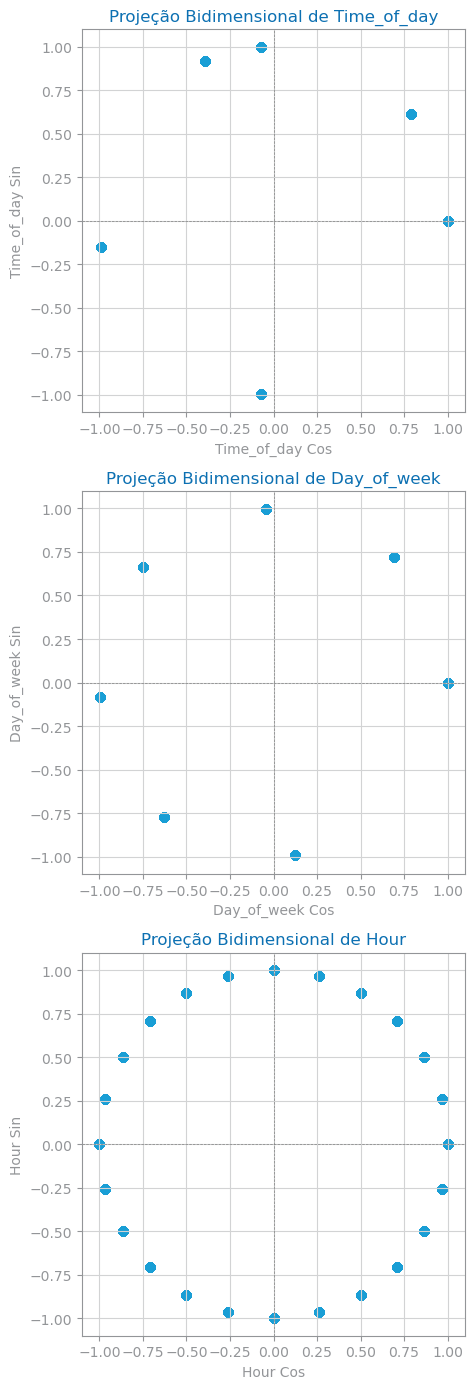

In [108]:
import matplotlib.pyplot as plt

# Lista de variáveis cíclicas
cyclical_vars = ['time_of_day', 'day_of_week', 'hour']

# Criar gráficos de dispersão para cada variável cíclica com tamanho maior
plt.figure(figsize=(14, 14))  # Aumentando o tamanho da figura

for i, var in enumerate(cyclical_vars):
    # Valores de seno e cosseno para a variável atual
    x_values = df_enc[f'{var}_cos']
    y_values = df_enc[f'{var}_sin']
    
    # Criar um subplot para cada variável
    plt.subplot(len(cyclical_vars), 1, i + 1)
    plt.scatter(x_values, y_values, alpha=0.6)
    plt.axhline(0, color='gray', lw=0.5, ls='--')
    plt.axvline(0, color='gray', lw=0.5, ls='--')
    
    # Ajustar os limites dos eixos para melhor visualização
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    
    # Adicionar título e rótulos
    plt.title(f'Projeção Bidimensional de {var.capitalize()}')
    plt.xlabel(f'{var.capitalize()} Cos')
    plt.ylabel(f'{var.capitalize()} Sin')
    
    # Mostrar a grade
    plt.grid()
    plt.gca().set_aspect('equal', adjustable='box')  # Para garantir que o gráfico é circular

plt.tight_layout()  # Ajustar o layout
plt.show()  # Mostrar todos os gráficos


#### Dummyifcation enconding
- Apply dummyification method to the following variables:
    - start_borough
    - end_borough
    - wmo_weather_desc


In [109]:
# Apply one-hot encoding to the symbolic variables
df_enc = pd.get_dummies(df_enc, columns=["start_borough", "end_borough", "wmo_weather_desc"], dtype=int)


display(df_enc.head())

,bike_type,user_type,day_of_month,is_weekend,ride_duration_min,temperature_2m,rain_mm,cloud_cover_low_pct,wind_speed_10m,ride_distance_km,...,end_borough_Staten Island,wmo_weather_desc_Clear sky,wmo_weather_desc_Drizzle: Dense,wmo_weather_desc_Drizzle: Light,wmo_weather_desc_Drizzle: Moderate,wmo_weather_desc_Mainly clear,wmo_weather_desc_Overcast,wmo_weather_desc_Partly cloudy,wmo_weather_desc_Rain: Moderate,wmo_weather_desc_Rain: Slight
0,1,1,27,1,9.161483,14.3,0.0,16,25.3,2.037884,...,0,0,0,0,0,0,1,0,0,0
1,1,1,25,0,4.639433,11.2,0.0,0,13.7,1.447460,...,0,1,0,0,0,0,0,0,0,0
2,1,1,6,1,6.865817,9.6,0.0,95,27.9,1.785276,...,0,0,0,0,0,0,1,0,0,0
3,1,1,6,1,2.289150,10.7,0.0,11,25.4,0.431973,...,0,0,0,0,0,0,1,0,0,0
4,1,1,10,0,7.947850,15.0,0.0,44,10.7,1.376807,...,0,0,0,0,0,0,0,1,0,0


In [110]:
df_enc.shape

(3193597, 39)

In [111]:
df_enc.columns

Index(['bike_type', 'user_type', 'day_of_month', 'is_weekend',
       'ride_duration_min', 'temperature_2m', 'rain_mm', 'cloud_cover_low_pct',
       'wind_speed_10m', 'ride_distance_km', 'ride_avg_speed',
       'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin',
       'day_of_week_cos', 'hour_sin', 'hour_cos', 'start_borough_Bronx',
       'start_borough_Brooklyn', 'start_borough_Jersey City',
       'start_borough_Manhattan', 'start_borough_Queens',
       'start_borough_Staten Island', 'end_borough_Bronx',
       'end_borough_Brooklyn', 'end_borough_Hoboken',
       'end_borough_Jersey City', 'end_borough_Manhattan',
       'end_borough_Queens', 'end_borough_Staten Island',
       'wmo_weather_desc_Clear sky', 'wmo_weather_desc_Drizzle: Dense',
       'wmo_weather_desc_Drizzle: Light', 'wmo_weather_desc_Drizzle: Moderate',
       'wmo_weather_desc_Mainly clear', 'wmo_weather_desc_Overcast',
       'wmo_weather_desc_Partly cloudy', 'wmo_weather_desc_Rain: Moderate',
       'wm

## correlation matrix  after enconding

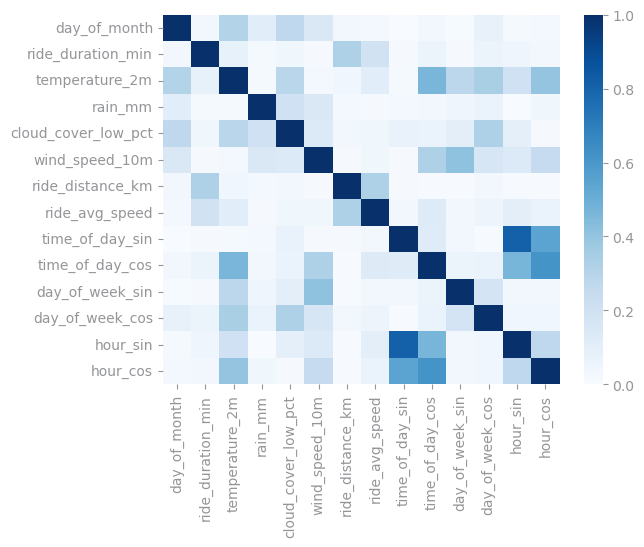

In [112]:
from seaborn import heatmap
from matplotlib.pyplot import figure, savefig, show

variables_types: dict[str, list] = get_variable_types(df_enc)
numeric: list[str] = variables_types["numeric"]
corr_mtx: DataFrame = df_enc[numeric].corr().abs()

figure()
heatmap(
    abs(corr_mtx),
    xticklabels=numeric,
    yticklabels=numeric,
    annot=False,
    cmap="Blues",
    vmin=0,
    vmax=1,
)
#savefig(f"images/{file_tag}_correlation_analysis.png")
show()

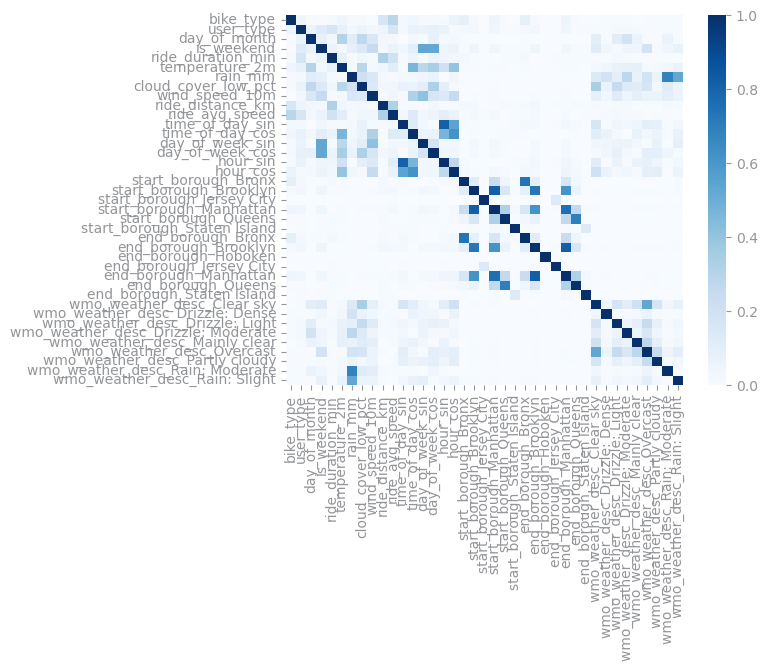

In [113]:
from seaborn import heatmap
from matplotlib.pyplot import figure, savefig, show

variables_types: dict[str, list] = get_variable_types(df_enc)
numeric: list[str] = variables_types["numeric"]
corr_mtx: DataFrame = df_enc.corr().abs()

figure()
heatmap(
    abs(corr_mtx),
    xticklabels=df_enc.columns,
    yticklabels=df_enc.columns,
    annot=False,
    cmap="Blues",
    vmin=0,
    vmax=1,
)
#savefig(f"images/{file_tag}_correlation_analysis.png")
show()

## Save final df from Data preparation - ENCODING into a csv file
- We will use this dataset for the missing alues

In [115]:
# Definir o caminho para salvar o arquivo CSV
filepath = r'data/citi_bike_data_prep_encoded.csv'

# Salvar o DataFrame em CSV
df_enc.to_csv(filepath, index=False)